In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
import seaborn as sns
import sklearn.metrics as metrics
from keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import r2_score

In [ ]:
data = pd.read_csv('BTC-USD.csv')
df = pd.read_csv('BTC-USD.csv')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [ ]:
print('Null Values:',data.isnull().values.sum())

Null Values: 0


In [ ]:
print('NA Values:',data.isna().values.any())

NA Values: False


In [ ]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2797.000000,2797.000000,2797.000000,2797.000000,2797.000000,2.797000e+03
mean,12179.001097,12498.700926,11824.655327,12187.967897,12187.967897,1.515505e+10
std,16626.024226,17058.244279,16128.072537,16624.230219,16624.230219,1.996364e+10
min,176.897003,211.731003,171.509995,178.102997,178.102997,5.914570e+06
25%,614.635010,621.317993,610.455017,616.752014,616.752014,8.352860e+07
50%,6468.500000,6567.540039,6363.620117,6475.740234,6475.740234,5.475580e+09
75%,11110.210938,11443.022461,10846.850586,11112.700195,11112.700195,2.577658e+10
max,67549.734375,68789.625000,66382.062500,67566.828125,67566.828125,3.509679e+11


In [ ]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
year_2021 = df.loc[(df['Date'] >= '2021-01-01') & (df['Date'] < '2022-01-01')]
year_2021.drop(year_2021[['High','Low','Volume']],axis=1)
months_2021 = year_2021.groupby(year_2021['Date'].dt.strftime('%B'))[['Open','Close']].mean()
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
months_2021 = round(months_2021.reindex(month_order, axis=0),2)
months_2021 = months_2021.reset_index()

In [ ]:
fig = px.line(df, x="Date", y="Close",title='Closing price-Line Plot')
fig.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



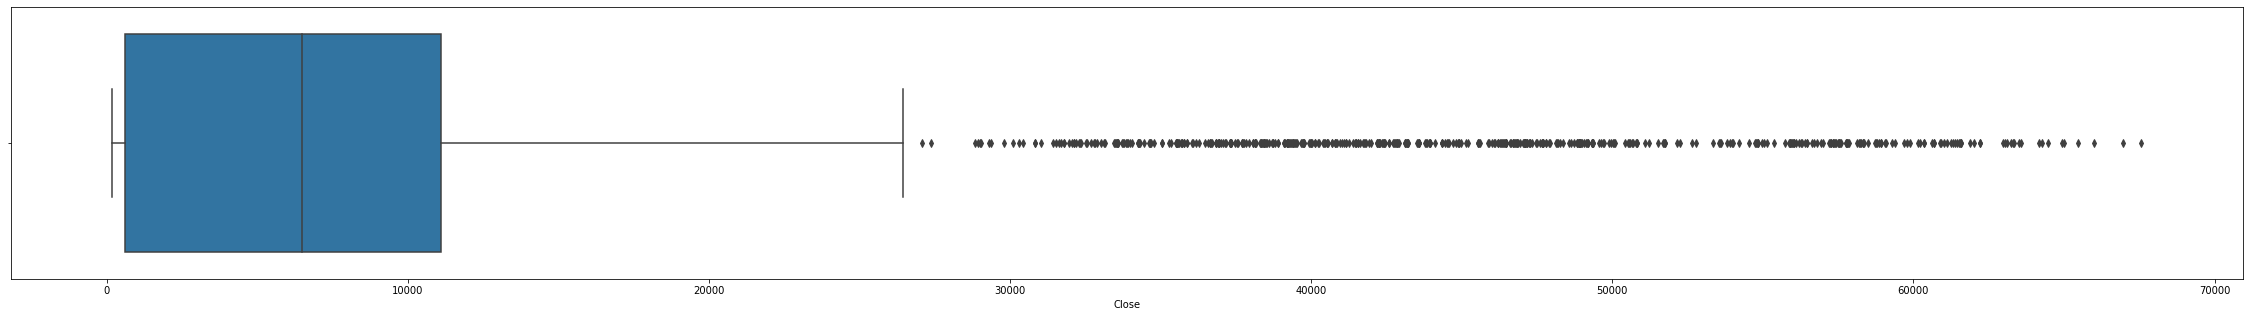

In [ ]:
fig, ax = plt.subplots(figsize=(40, 5))
g=sns.boxplot(data['Close'])

In [ ]:
fig = px.bar(months_2021, x='Date', y=['Close'], barmode='group', title = 'Monthly Average Open & Close Price - Year 2021')
#px.set_facecolor('xkcd:black')
fig.update_traces(marker_color='green')
fig.show()

In [ ]:
data_training = data[data['Date']< '2019-03-01'].copy()
data_training.shape

(1626, 7)

In [ ]:
data_test = data[data['Date']> '2019-03-01'].copy()
data_test.shape

(1170, 7)

In [ ]:
 training_data = data_training.drop(['Date', 'Adj Close'],axis=1)
 training_data.head()

,Open,High,Low,Close,Volume
0,465.864014,468.174011,452.421997,457.334015,21056800
1,456.859985,456.859985,413.104004,424.440002,34483200
2,424.102997,427.834991,384.532013,394.795990,37919700
3,394.673004,423.295990,389.882996,408.903992,36863600
4,408.084991,412.425995,393.181000,398.821014,26580100


In [ ]:
scaler = MinMaxScaler()
training_data_df = pd.DataFrame(scaler.fit_transform(training_data))
training_data=scaler.fit_transform(training_data)
training_data_df

,0,1,2,3,4
0,0.014973,0.012901,0.014940,0.014453,0.000635
1,0.014507,0.012332,0.012849,0.012751,0.001199
2,0.012809,0.010872,0.011329,0.011216,0.001343
3,0.011284,0.010644,0.011614,0.011947,0.001298
4,0.011979,0.010097,0.011789,0.011425,0.000867
...,...,...,...,...,...
1621,0.205637,0.201180,0.192644,0.188015,0.452625
1622,0.188099,0.186242,0.193351,0.191756,0.390723
1623,0.191814,0.185128,0.194998,0.190289,0.332507
1624,0.190715,0.184989,0.192290,0.190118,0.348034


In [ ]:
training_data.shape

(1626, 5)

In [ ]:
X_train = [] 
Y_train = []
for i in range(60, training_data.shape[0]):
   X_train.append(training_data[i-60:i])
   Y_train.append(training_data[i,0])
X_train, Y_train = np.array(X_train), np.array(Y_train)

In [ ]:
X_train.shape


(1566, 60, 5)

In [ ]:
Y_train.shape

(1566,)

In [ ]:
model = Sequential()
model.add(LSTM(units = 100, activation = 'relu', return_sequences = True, input_shape = (X_train.shape[1], 5)))
model.add(Dropout(0.2)) 
model.add(LSTM(units = 200, activation = 'relu', return_sequences = True))
model.add(Dropout(0.3))
model.add(LSTM(units = 300, activation = 'relu'))
model.add(Dropout(0.4)) 
model.add(Dense(units =1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 100)           42400     
                                                                 
 dropout (Dropout)           (None, 60, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 200)           240800    
                                                                 
 dropout_1 (Dropout)         (None, 60, 200)           0         
                                                                 
 lstm_2 (LSTM)               (None, 300)               601200    
                                                                 
 dropout_2 (Dropout)         (None, 300)               0         
                                                                 
 dense (Dense)               (None, 1)                 3

In [ ]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['mse'])
lstm_model= model.fit(X_train, Y_train, epochs = 5, batch_size =50, validation_split=0.1)

Epoch 1/5
29/29 [==============================] - 24s 692ms/step - loss: 0.0034 - mse: 0.0034 - val_loss: 4.5797e-04 - val_mse: 4.5797e-04
Epoch 2/5
29/29 [==============================] - 19s 648ms/step - loss: 0.0020 - mse: 0.0020 - val_loss: 4.5616e-04 - val_mse: 4.5616e-04
Epoch 3/5
29/29 [==============================] - 19s 658ms/step - loss: 0.0023 - mse: 0.0023 - val_loss: 0.0015 - val_mse: 0.0015
Epoch 4/5
29/29 [==============================] - 19s 652ms/step - loss: 0.0023 - mse: 0.0023 - val_loss: 4.0767e-04 - val_mse: 4.0767e-04
Epoch 5/5
29/29 [==============================] - 19s 647ms/step - loss: 0.0020 - mse: 0.0020 - val_loss: 7.1915e-04 - val_mse: 7.1915e-04


In [ ]:
df = data_test.drop(['Date', 'Adj Close'], axis = 1)
df.head()

,Open,High,Low,Close,Volume
1627,3855.318115,3874.607422,3832.127930,3864.415039,7578786076
1628,3862.266113,3875.483643,3836.905762,3847.175781,7253558152
1629,3845.091553,3867.381836,3733.749756,3761.557129,9029175788
1630,3759.832520,3903.916748,3745.183105,3896.375000,10174126415
1631,3897.081055,3919.510498,3871.460693,3903.942627,9175291529


In [ ]:
inputs = scaler.fit_transform(df) 
inputs

array([[1.49687634e-03, 1.11296000e-04, 1.57032440e-03, 1.61205976e-03,
        9.46215637e-04],
       [1.60579637e-03, 1.24792469e-04, 1.64658873e-03, 1.34187428e-03,
        0.00000000e+00],
       [1.33656003e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        5.16596838e-03],
       ...,
       [3.94684756e-01, 4.03021466e-01, 3.61011167e-01, 3.96302601e-01,
        1.73794342e-01],
       [3.96161099e-01, 4.16766575e-01, 3.99828491e-01, 3.99991192e-01,
        1.03538194e-01],
       [4.00154402e-01, 4.05491548e-01, 3.98560780e-01, 4.12813990e-01,
        6.20466047e-02]])

In [ ]:
X_test = []
Y_test = []
inputs.shape[0]
for i in range (60, inputs.shape[0]):
  X_test.append(inputs[i-60:i]) 
  Y_test.append(inputs[i, 0])

X_test = np.array(X_test)
Y_test =  np.array(Y_test)

In [ ]:
Y_test.shape

(1110,)

In [ ]:
X_test


In [ ]:
Y_pred = model.predict(X_test,batch_size=50)

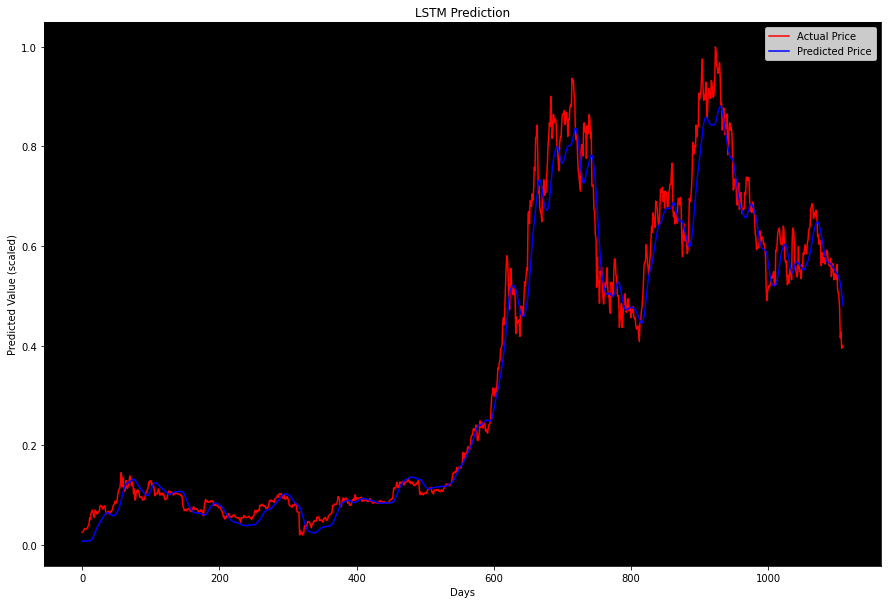

In [ ]:
plt.figure(figsize=(15,10))
plt.title('LSTM Prediction')
plt.xlabel('Days')
plt.ylabel('Predicted Value (scaled)')
plt.plot(Y_test, color = 'red', label = 'Actual Price')
plt.plot(Y_pred, color = 'blue', label = 'Predicted Price')
ax = plt.gca()
ax.set_facecolor('xkcd:black')
plt.legend()
plt.show()

In [ ]:
r2_score(Y_test,Y_pred)*100

97.86040322368844